# Setup enviorment

In [1]:
%cd ..

/home/datascience/TOP 10 Municipalities Models


In [2]:
from Preprocessing.time_series_preprocessing import get_dengue_dataset, train_test_split, normalize_train_features, normalize_test_features, series_to_supervised, features_labels_set, reshape_tensor

from Models.LSTM import create_model, train_model
import tensorflow as tf

from Utils.test_lstm import evaluate, plot_predictions, calculate_mean_std

import pandas as pd
import os
import numpy as np

In [3]:
""" Read Dataset:"""

embeddings = 'Embeddings/ResNet50V2_Per_Band/224_band11.csv'
labels = '../Tabular_data/dengue_tabular.csv'

# Get list of municipalities:
Municipalities = list(pd.unique(pd.read_csv(embeddings)['Municipality Code']))

""" Dataset Preprocessing:"""
train_percentage = 80
T = 0
autoregressive = False
feature_range = (-1, 1)

""" Model Parameters:"""
lstm_layers=[1000, 500]
nn_layers=[250, 120, 1]
dense_acivation='relu'
recurrent_cells='LSTM'
bidirectional=False

## 1. Read Data

In [4]:
# Read dataset for top 5 municipalities
dengue_df = [get_dengue_dataset(labels_path=labels, embeddings_path=embeddings, municipality=Municipality) for Municipality in Municipalities]
type(dengue_df)

Obtaining dataframe for the city of 54001 - Cúcuta only...
Obtaining dataframe for the city of 41001 - Neiva only...
Obtaining dataframe for the city of 5001 - Medellín only...
Obtaining dataframe for the city of 50001 - Villavicencio only...
Obtaining dataframe for the city of 68001 - Bucaramanga only...
Obtaining dataframe for the city of 8001 - Barranquilla only...
Obtaining dataframe for the city of 23001 - Montería only...
Obtaining dataframe for the city of 76001 - Cali only...
Obtaining dataframe for the city of 73001 - Ibagué only...
Obtaining dataframe for the city of 5360 - Itagüí only...


list

### Train Test split

In [5]:
train_df = []
test_df = []

for i in range(len(dengue_df)):
    train_df_aux, test_df_aux = train_test_split(dengue_df[i], train_percentage)
    train_df.append(train_df_aux)
    test_df.append(test_df_aux)
#test_df

The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)


### Normalize features

In [6]:
# Merge:
train_df = pd.concat(train_df, keys=Municipalities)
test_df = pd.concat(test_df, keys=Municipalities)

In [7]:
# Scale train:
train_df, scalers = normalize_train_features(train_df, feature_range=feature_range)
train_df = [train_df[train_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

#print(f'The scalers are: {scalers}')

train_df[1].head()

0    1        2         3         4    5    6    7    8  \
41001 201546 -1.0 -1.0 -0.96449 -0.404157 -0.954127 -1.0 -1.0 -1.0 -1.0   
      201547 -1.0 -1.0 -0.96449 -0.404157 -0.954127 -1.0 -1.0 -1.0 -1.0   
      201548 -1.0 -1.0 -0.96449 -0.404157 -0.954127 -1.0 -1.0 -1.0 -1.0   
      201549 -1.0 -1.0 -0.96449 -0.404157 -0.954127 -1.0 -1.0 -1.0 -1.0   
      201550 -1.0 -1.0 -0.96449 -0.404157 -0.954127 -1.0 -1.0 -1.0 -1.0   

                   9  ...  2039      2040      2041  2042  2043      2044  \
41001 201546 -0.9543  ...  -1.0 -0.933497 -0.919513  -1.0  -1.0 -0.866862   
      201547 -0.9543  ...  -1.0 -0.933497 -0.919513  -1.0  -1.0 -0.866862   
      201548 -0.9543  ...  -1.0 -0.933497 -0.919513  -1.0  -1.0 -0.866862   
      201549 -0.9543  ...  -1.0 -0.933497 -0.919513  -1.0  -1.0 -0.866862   
      201550 -0.9543  ...  -1.0 -0.933497 -0.919513  -1.0  -1.0 -0.866862   

              2045      2046  2047    Labels  
41001 201546  -1.0 -0.945283  -1.0 -0.861740  
      201547  -1.0 -0.945283  -1.0 -0.854589  
      201548  -1.0 -0.945283  -1.0 -0.856973  
      201549  -1.0 -0.945283  -1.0 -0.856973  
      201550  -1.0 -0.945283  -1.0 -0.823600  

[5 rows x 2049 columns]

In [8]:
# Scale test:
test_df = normalize_test_features(test_df, scalers=scalers)
test_df = [test_df[test_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

test_df[1].head()

0         1         2         3         4    5         6    7  \
41001 201820 -1.0 -0.939359 -0.849639 -0.997266 -0.603637 -1.0 -0.990546 -1.0   
      201821 -1.0 -0.892988 -0.989402 -1.000000 -1.000000 -1.0 -0.474970 -1.0   
      201822 -1.0 -0.988961 -0.936540 -1.000000 -0.970936 -1.0 -0.963687 -1.0   
      201823 -1.0 -0.947311 -0.888202 -1.000000 -0.946768 -1.0 -1.000000 -1.0   
      201824 -1.0 -1.000000 -0.934540 -1.000000 -1.000000 -1.0 -0.255670 -1.0   

                     8         9  ...  2039      2040  2041  2042      2043  \
41001 201820 -0.872896 -1.000000  ...  -1.0 -0.072201  -1.0  -1.0 -0.995330   
      201821 -1.000000 -1.000000  ...  -1.0 -0.209719  -1.0  -1.0 -0.378218   
      201822 -0.943798 -1.000000  ...  -1.0 -0.560958  -1.0  -1.0 -0.640524   
      201823 -0.991363 -0.936498  ...  -1.0 -0.983532  -1.0  -1.0 -0.998895   
      201824 -0.956177 -1.000000  ...  -1.0 -0.934064  -1.0  -1.0 -0.924552   

                  2044  2045      2046      2047    Labels  
41001 201820 -1.000000  -1.0 -0.740744 -1.000000 -0.949940  
      201821 -0.994081  -1.0 -0.682413 -0.958507 -0.961859  
      201822 -1.000000  -1.0  0.273493 -1.000000 -0.940405  
      201823 -1.000000  -1.0 -0.991552 -1.000000 -0.961859  
      201824 -0.943203  -1.0 -0.254245 -0.684136 -0.954708  

[5 rows x 2049 columns]

### Prepare data for time series supervised learning (function to create sliding window)

In [9]:
# frame as supervised learning
train = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in train_df]
test = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in test_df]

train[1].shape

(130, 2049)

### Merge train data

In [10]:
# Merge:
train = pd.concat(train, keys=Municipalities)
test = pd.concat(test, keys=Municipalities)

In [11]:
train.shape

(1300, 2049)

### Features and Labels Set

In [12]:
# Train features and labels set
print('Train:')
train_X, train_y, n_features = features_labels_set(timeseries_data=train, original_df=dengue_df[0], autoregressive=autoregressive)

# Test features and labels set
print('Test:')
test_X, test_y, n_features = features_labels_set(timeseries_data=test, original_df=dengue_df[0], autoregressive=autoregressive)

Train:
The shape of the features is (1300, 2048)
The shape of the labels is (1300, 1)
Test:
The shape of the features is (330, 2048)
The shape of the labels is (330, 1)


In [13]:
# reshape input to be 3D [samples, timesteps, features]
if T != 0:
    train_X, test_X = reshape_tensor(train_X, test_X, n_features, T, autoregressive)

# 2. Model

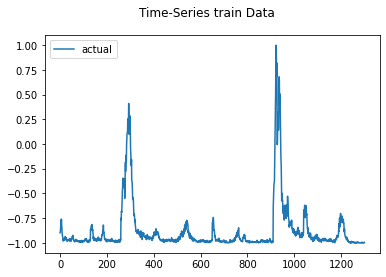

2023-03-07 14:51:50.124714: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-07 14:51:50.124766: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-07 14:51:50.124797: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (9e0b1a08816a): /proc/driver/nvidia/version does not exist
2023-03-07 14:51:50.125356: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-07 14:51:50.589082: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] 

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 174.712
Test RMSE: 228.240
Test sMAPE: 163.129
Test R Squared: -52.904
{'mae': 174.71191851225765, 'rmse': 228.2397539045331, 'smape': 163.12920464624685, 'r2': -52.904445436599005}


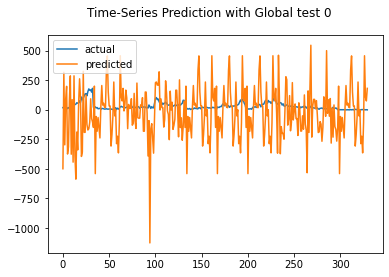

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 1265.307
Test RMSE: 1412.027
Test sMAPE: 199.938
Test R Squared: -2062.138
{'mae': 1265.306613667806, 'rmse': 1412.0274661246513, 'smape': 199.93842791632449, 'r2': -2062.1380591673756}


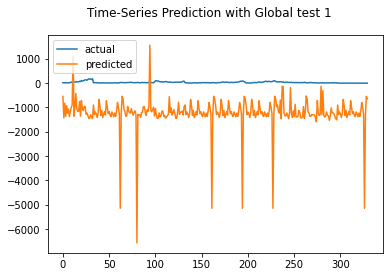

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 240.807
Test RMSE: 396.619
Test sMAPE: 162.321
Test R Squared: -161.776
{'mae': 240.80689599369512, 'rmse': 396.6190282763152, 'smape': 162.32119731990193, 'r2': -161.77552097237066}


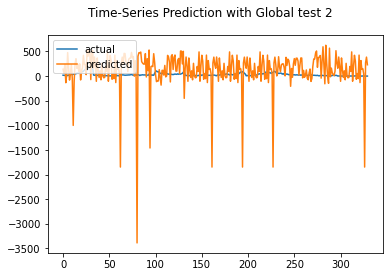

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 1206.882
Test RMSE: 2696.088
Test sMAPE: 186.474
Test R Squared: -7520.599
{'mae': 1206.8816747954397, 'rmse': 2696.088142748096, 'smape': 186.474318501304, 'r2': -7520.598971951708}


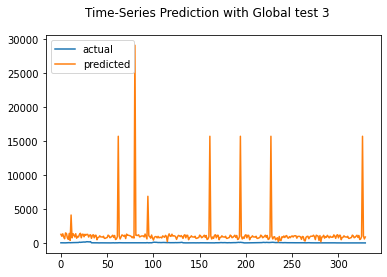

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 281.627
Test RMSE: 1141.542
Test sMAPE: 153.483
Test R Squared: -1347.422
{'mae': 281.6274781124158, 'rmse': 1141.5422140959254, 'smape': 153.4829611201549, 'r2': -1347.4223870104436}


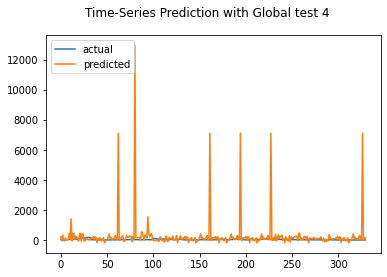

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 552.664
Test RMSE: 1824.743
Test sMAPE: 169.414
Test R Squared: -3444.447
{'mae': 552.6636489752567, 'rmse': 1824.7433794006538, 'smape': 169.41354098583534, 'r2': -3444.4471678220425}


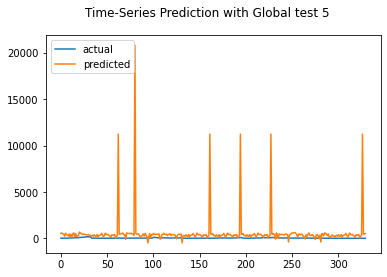

Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Test MAE: 346.364
Test RMSE: 1621.356
Test sMAPE: 152.998
Test R Squared: -2719.186
{'mae': 346.36414608666394, 'rmse': 1621.35570973746, 'smape': 152.998127723069, 'r2': -2719.1860699959075}


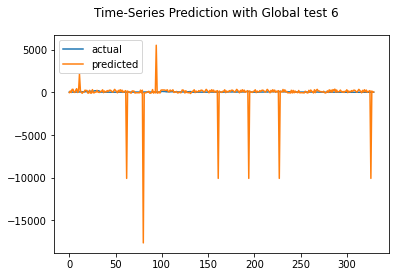

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 310.770
Test RMSE: 785.228
Test sMAPE: 154.152
Test R Squared: -637.019
{'mae': 310.7703902732242, 'rmse': 785.2283366150161, 'smape': 154.15226249865682, 'r2': -637.0194655273416}


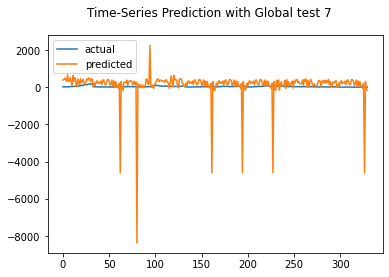

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 1976.317
Test RMSE: 2431.740
Test sMAPE: 193.390
Test R Squared: -6117.943
{'mae': 1976.3166655106977, 'rmse': 2431.740282724658, 'smape': 193.39028249279676, 'r2': -6117.942609055717}


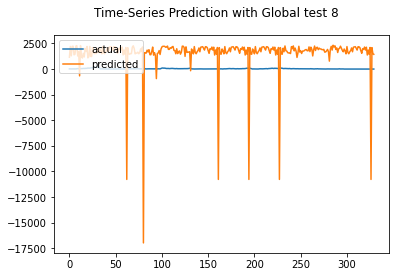

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 106.099
Test RMSE: 179.169
Test sMAPE: 140.285
Test R Squared: -32.218
{'mae': 106.09869834726507, 'rmse': 179.16934419479952, 'smape': 140.28494372476328, 'r2': -32.21768862432986}


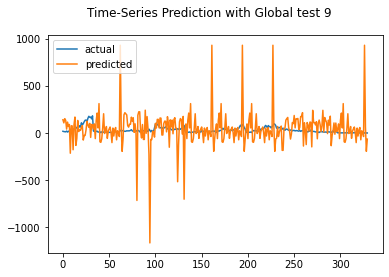

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 388.182
Test RMSE: 1945.157
Test sMAPE: 145.889
Test R Squared: -3914.178
{'mae': 388.18247180599155, 'rmse': 1945.1573267198337, 'smape': 145.88883990475432, 'r2': -3914.1776099009944}


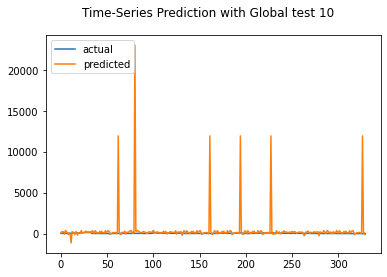

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 576.175
Test RMSE: 1921.668
Test sMAPE: 191.865
Test R Squared: -3820.192
{'mae': 576.1754831776475, 'rmse': 1921.6682620528773, 'smape': 191.86484974611267, 'r2': -3820.191795481224}


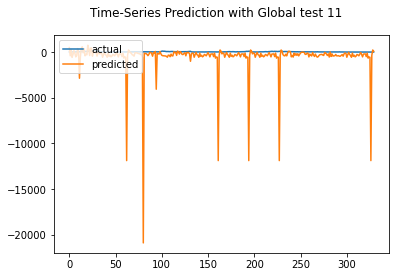

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 1026.298
Test RMSE: 1104.128
Test sMAPE: 199.899
Test R Squared: -1260.480
{'mae': 1026.2978861490885, 'rmse': 1104.1275748500257, 'smape': 199.89942938498288, 'r2': -1260.480420282878}


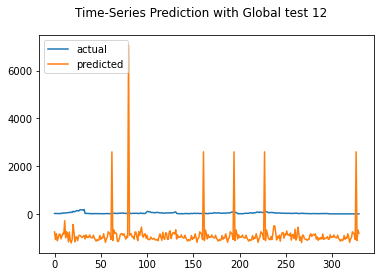

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 160.819
Test RMSE: 300.152
Test sMAPE: 144.030
Test R Squared: -92.224
{'mae': 160.8189561294787, 'rmse': 300.1524855159218, 'smape': 144.02987164480191, 'r2': -92.22360423521592}


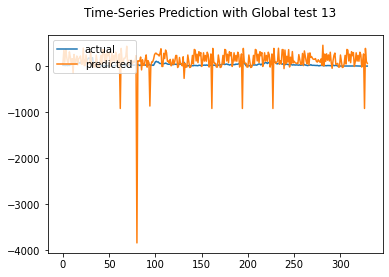

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 156.056
Test RMSE: 324.992
Test sMAPE: 155.021
Test R Squared: -108.292
{'mae': 156.05588052146362, 'rmse': 324.9923664261219, 'smape': 155.02115890864496, 'r2': -108.29198706102807}


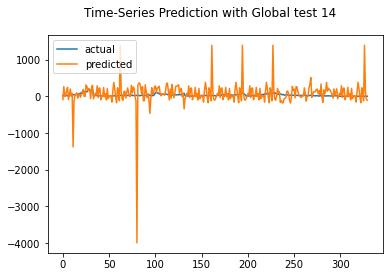

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 146.424
Test RMSE: 246.680
Test sMAPE: 157.363
Test R Squared: -61.967
{'mae': 146.42416311231526, 'rmse': 246.68032504752912, 'smape': 157.36304203642965, 'r2': -61.96671342466558}


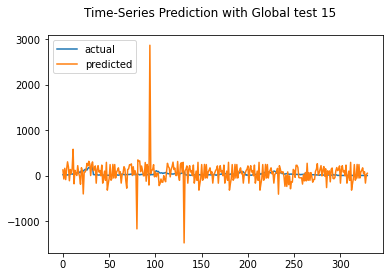

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 142.358
Test RMSE: 192.878
Test sMAPE: 167.443
Test R Squared: -37.495
{'mae': 142.35765155806686, 'rmse': 192.87811461329045, 'smape': 167.44325795669445, 'r2': -37.49531750338663}


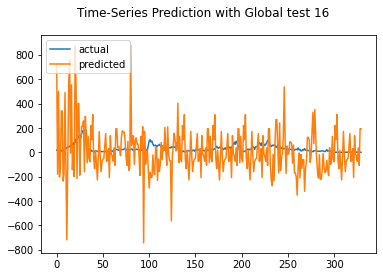

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 124.911
Test RMSE: 214.548
Test sMAPE: 156.557
Test R Squared: -46.631
{'mae': 124.91068672826796, 'rmse': 214.5479305848832, 'smape': 156.55726649577898, 'r2': -46.6311055060646}


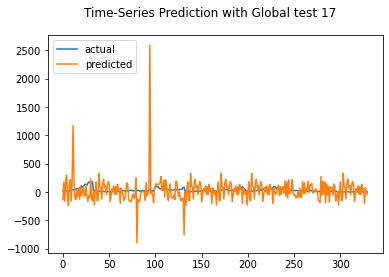

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 173.548
Test RMSE: 488.073
Test sMAPE: 146.390
Test R Squared: -245.497
{'mae': 173.5478166273146, 'rmse': 488.0733188094058, 'smape': 146.39013522763415, 'r2': -245.49728244517487}


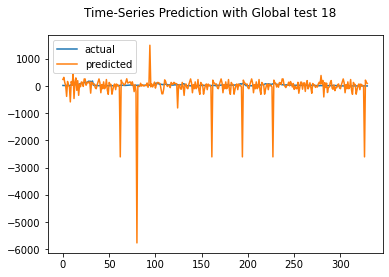

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 140.516
Test RMSE: 300.393
Test sMAPE: 129.287
Test R Squared: -92.373
{'mae': 140.51632555470323, 'rmse': 300.3926030232636, 'smape': 129.28688172765132, 'r2': -92.37281887934309}


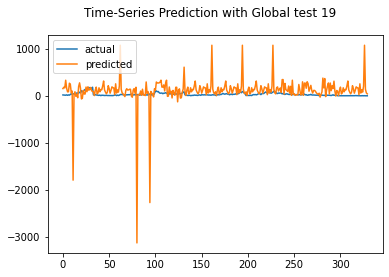

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 218.991
Test RMSE: 408.387
Test sMAPE: 181.248
Test R Squared: -171.578
{'mae': 218.99087756402565, 'rmse': 408.3872850242226, 'smape': 181.24797969206801, 'r2': -171.57839502464262}


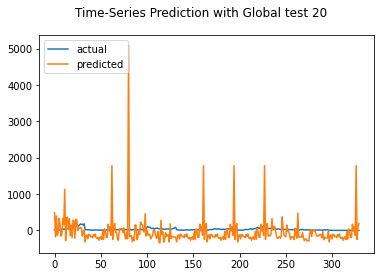

Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping
Test MAE: 75.610
Test RMSE: 158.009
Test sMAPE: 136.206
Test R Squared: -24.835
{'mae': 75.60974414186045, 'rmse': 158.0088636844535, 'smape': 136.20559624376116, 'r2': -24.834787960229047}


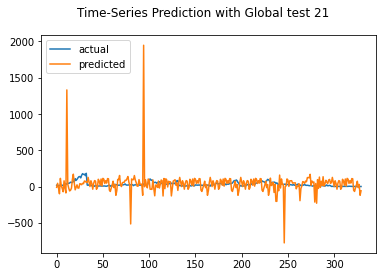

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 310.371
Test RMSE: 713.790
Test sMAPE: 171.101
Test R Squared: -526.209
{'mae': 310.3714075484059, 'rmse': 713.7900220405561, 'smape': 171.1007115402285, 'r2': -526.2091597739178}


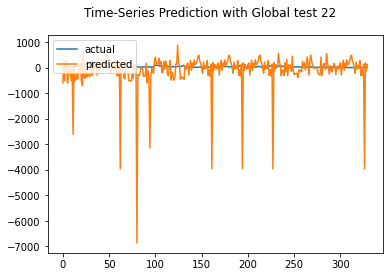

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 132.055
Test RMSE: 296.739
Test sMAPE: 142.074
Test R Squared: -90.115
{'mae': 132.05467494581686, 'rmse': 296.7389692187469, 'smape': 142.07405339136187, 'r2': -90.11527056866983}


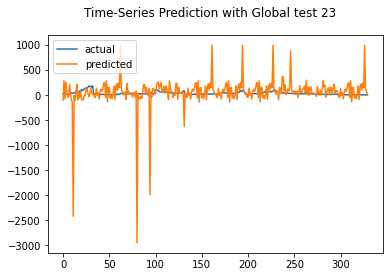

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 114.924
Test RMSE: 151.735
Test sMAPE: 158.403
Test R Squared: -22.824
{'mae': 114.92415812783169, 'rmse': 151.73468528897556, 'smape': 158.4030044079939, 'r2': -22.8238385981874}


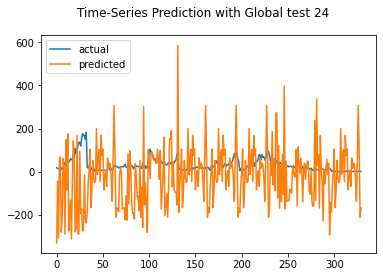

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 283.037
Test RMSE: 1407.796
Test sMAPE: 162.688
Test R Squared: -2049.790
{'mae': 283.0371470380913, 'rmse': 1407.7955855217429, 'smape': 162.68763684097618, 'r2': -2049.7900408711503}


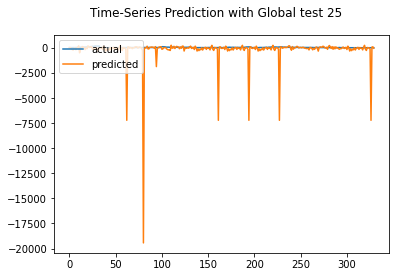

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 1880.888
Test RMSE: 3190.718
Test sMAPE: 192.170
Test R Squared: -10533.618
{'mae': 1880.8877336906664, 'rmse': 3190.717727144397, 'smape': 192.17033101140277, 'r2': -10533.617514545374}


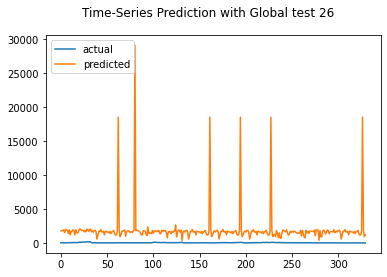

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAE: 104.361
Test RMSE: 457.451
Test sMAPE: 140.900
Test R Squared: -215.536
{'mae': 104.3613626700459, 'rmse': 457.45066692856926, 'smape': 140.89998046178954, 'r2': -215.53621037076783}


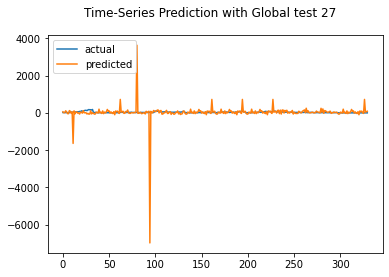

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 1442.679
Test RMSE: 1521.153
Test sMAPE: 191.613
Test R Squared: -2393.352
{'mae': 1442.67939453125, 'rmse': 1521.153306747942, 'smape': 191.61262969729935, 'r2': -2393.351866826293}


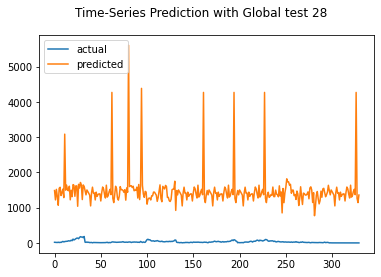

Test MAE: 226.352
Test RMSE: 1106.705
Test sMAPE: 123.105
Test R Squared: -1266.377
{'mae': 226.3515781321309, 'rmse': 1106.7051620200898, 'smape': 123.1046294814601, 'r2': -1266.3771503791686}


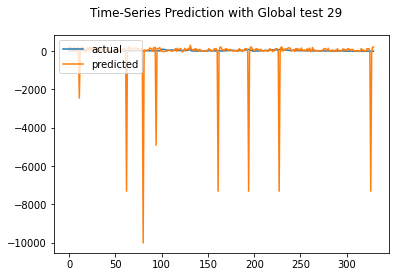

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 193.191
Test RMSE: 422.889
Test sMAPE: 164.318
Test R Squared: -184.052
{'mae': 193.19109249060804, 'rmse': 422.888645428543, 'smape': 164.3179636620458, 'r2': -184.05211394769967}


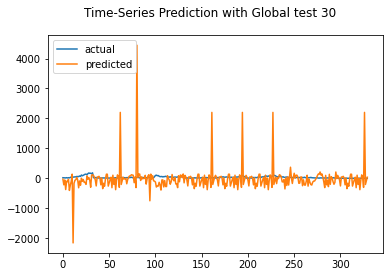

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 159.910
Test RMSE: 302.139
Test sMAPE: 179.142
Test R Squared: -93.462
{'mae': 159.91045835740638, 'rmse': 302.1390117211279, 'smape': 179.14150708317376, 'r2': -93.46166805472524}


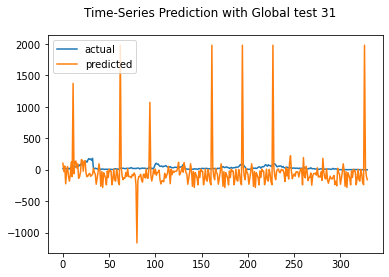

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 252.407
Test RMSE: 374.026
Test sMAPE: 160.078
Test R Squared: -143.759
{'mae': 252.40690995346415, 'rmse': 374.0262566283454, 'smape': 160.07849183576405, 'r2': -143.7592029220495}


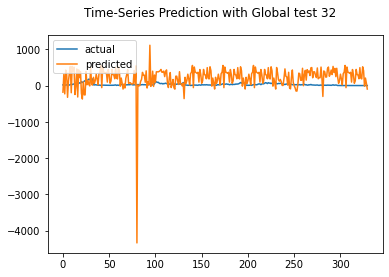

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 191.206
Test RMSE: 708.819
Test sMAPE: 132.690
Test R Squared: -518.891
{'mae': 191.2058342333996, 'rmse': 708.8188758822768, 'smape': 132.68979497797255, 'r2': -518.891300482763}


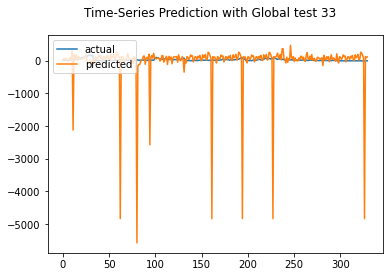

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 1118.717
Test RMSE: 2225.704
Test sMAPE: 199.892
Test R Squared: -5124.978
{'mae': 1118.717290242513, 'rmse': 2225.7038681434888, 'smape': 199.89213248661932, 'r2': -5124.978293942843}


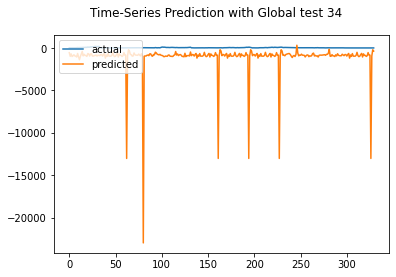

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 308.284
Test RMSE: 816.076
Test sMAPE: 148.637
Test R Squared: -688.133
{'mae': 308.2839983174295, 'rmse': 816.0756964062019, 'smape': 148.63721698762316, 'r2': -688.1327510600057}


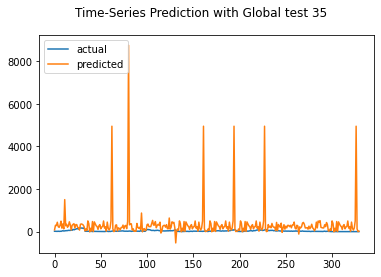

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 260.181
Test RMSE: 490.910
Test sMAPE: 174.659
Test R Squared: -248.371
{'mae': 260.1810918340177, 'rmse': 490.9103296326223, 'smape': 174.65947090920122, 'r2': -248.37122731108437}


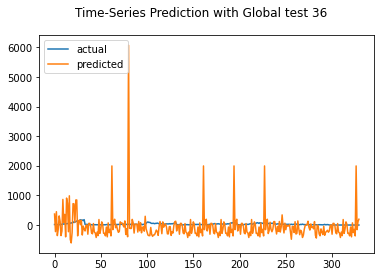

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 98.231
Test RMSE: 222.118
Test sMAPE: 126.469
Test R Squared: -50.052
{'mae': 98.23145734396847, 'rmse': 222.1183579700249, 'smape': 126.46870256389604, 'r2': -50.05178248322472}


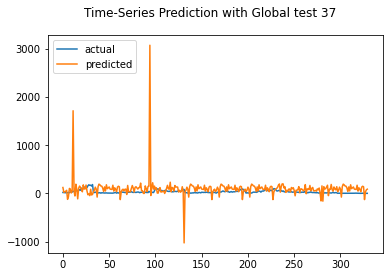

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAE: 102.814
Test RMSE: 301.717
Test sMAPE: 128.875
Test R Squared: -93.198
{'mae': 102.8142185169639, 'rmse': 301.71693353800185, 'smape': 128.8750468992499, 'r2': -93.1979327606938}


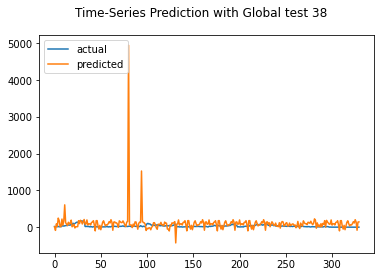

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 241.341
Test RMSE: 358.814
Test sMAPE: 160.427
Test R Squared: -132.223
{'mae': 241.3410977016796, 'rmse': 358.8139882715831, 'smape': 160.42670907630875, 'r2': -132.22346738767195}


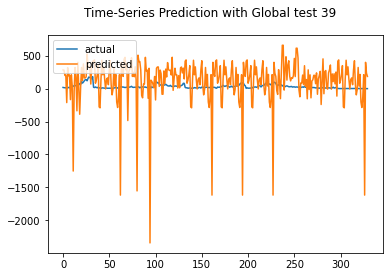

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 129.402
Test RMSE: 302.981
Test sMAPE: 128.676
Test R Squared: -93.989
{'mae': 129.40193660186998, 'rmse': 302.98111716526, 'smape': 128.67581776155944, 'r2': -93.98895871194243}


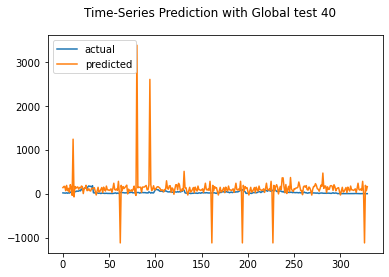

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 1567.489
Test RMSE: 2183.259
Test sMAPE: 190.670
Test R Squared: -4931.333
{'mae': 1567.4892190644234, 'rmse': 2183.258698000876, 'smape': 190.67004859708206, 'r2': -4931.333113723343}


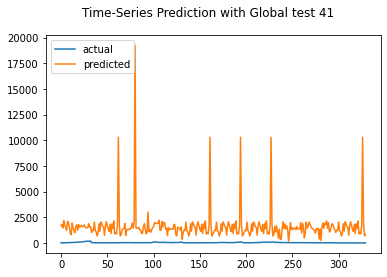

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 230.310
Test RMSE: 410.304
Test sMAPE: 176.192
Test R Squared: -173.202
{'mae': 230.3100265719674, 'rmse': 410.30369446948566, 'smape': 176.1923747701611, 'r2': -173.20188761036087}


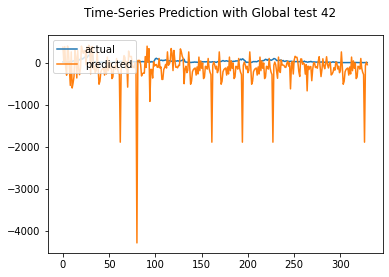

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 159.160
Test RMSE: 507.571
Test sMAPE: 140.620
Test R Squared: -265.585
{'mae': 159.16026298990755, 'rmse': 507.5714343892789, 'smape': 140.6197634708548, 'r2': -265.585391229641}


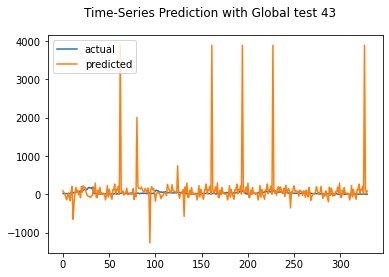

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 1355.698
Test RMSE: 1821.780
Test sMAPE: 190.229
Test R Squared: -3433.267
{'mae': 1355.698212964607, 'rmse': 1821.7803294414057, 'smape': 190.22947418323687, 'r2': -3433.2666989367817}


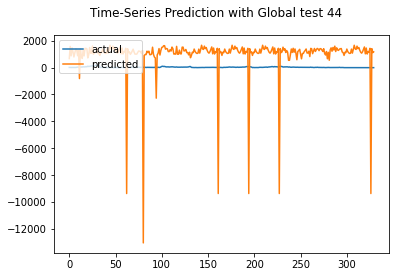

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 121.366
Test RMSE: 236.617
Test sMAPE: 141.468
Test R Squared: -56.934
{'mae': 121.36647745136058, 'rmse': 236.6169226796749, 'smape': 141.46822239053262, 'r2': -56.93401205327783}


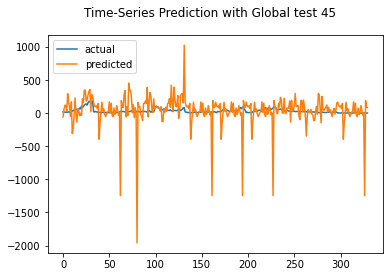

Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Test MAE: 105.527
Test RMSE: 438.210
Test sMAPE: 142.721
Test R Squared: -197.704
{'mae': 105.52676938889604, 'rmse': 438.2104170380509, 'smape': 142.72064750366906, 'r2': -197.70435985831193}


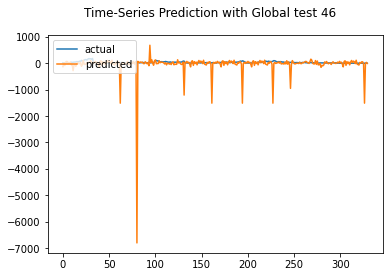

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 129.782
Test RMSE: 280.891
Test sMAPE: 150.019
Test R Squared: -80.643
{'mae': 129.7823413043311, 'rmse': 280.89088339061277, 'smape': 150.0189365064635, 'r2': -80.64268698199835}


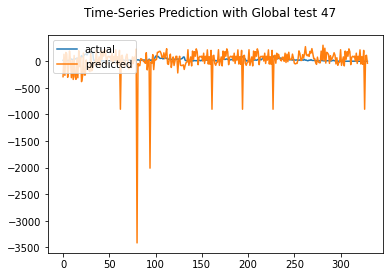

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 454.187
Test RMSE: 1077.011
Test sMAPE: 198.622
Test R Squared: -1199.280
{'mae': 454.1870819525285, 'rmse': 1077.0111415629717, 'smape': 198.62240663120244, 'r2': -1199.279514018841}


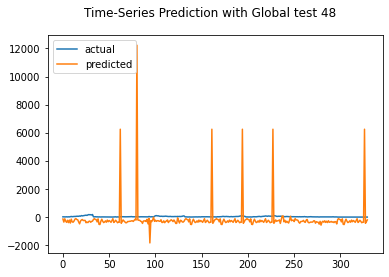

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 128.304
Test RMSE: 544.296
Test sMAPE: 158.421
Test R Squared: -305.558
{'mae': 128.3040154382135, 'rmse': 544.2958674627116, 'smape': 158.4207517625462, 'r2': -305.5575916930662}


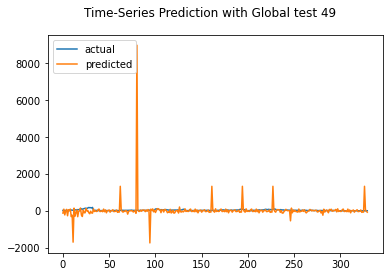

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 144.150
Test RMSE: 188.633
Test sMAPE: 162.666
Test R Squared: -35.819
{'mae': 144.15030114993905, 'rmse': 188.63266474341546, 'smape': 162.66583246943568, 'r2': -35.81932322386465}


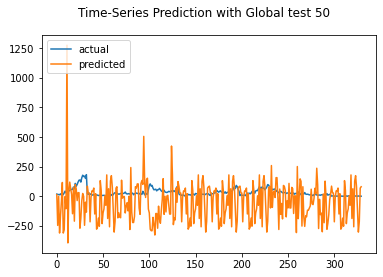

Test MAE: 247.469
Test RMSE: 1337.194
Test sMAPE: 117.070
Test R Squared: -1849.251
{'mae': 247.46912538535668, 'rmse': 1337.1936386079192, 'smape': 117.0699695606211, 'r2': -1849.2508202070044}


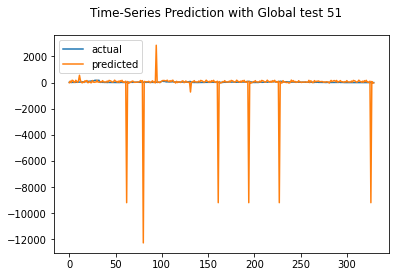

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 99.609
Test RMSE: 202.039
Test sMAPE: 140.643
Test R Squared: -41.239
{'mae': 99.60928234087699, 'rmse': 202.03921447582687, 'smape': 140.642662137579, 'r2': -41.23897242560876}


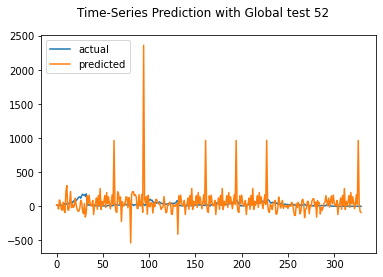

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAE: 89.181
Test RMSE: 167.032
Test sMAPE: 133.413
Test R Squared: -27.870
{'mae': 89.18080160202402, 'rmse': 167.03167392367905, 'smape': 133.4131753858848, 'r2': -27.869527009848788}


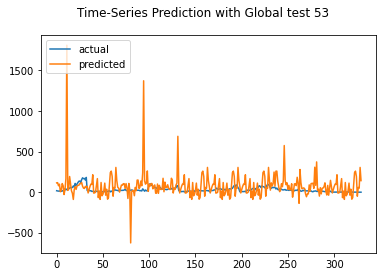

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 994.193
Test RMSE: 1027.302
Test sMAPE: 187.952
Test R Squared: -1091.039
{'mae': 994.1934388594194, 'rmse': 1027.3020495885683, 'smape': 187.9520810852394, 'r2': -1091.0394079101218}


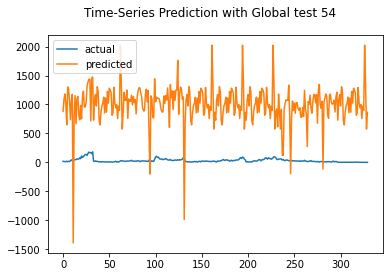

Test MAE: 441.627
Test RMSE: 2929.164
Test sMAPE: 108.197
Test R Squared: -8877.290
{'mae': 441.62733735387974, 'rmse': 2929.1638425029205, 'smape': 108.19660048362766, 'r2': -8877.290084519855}


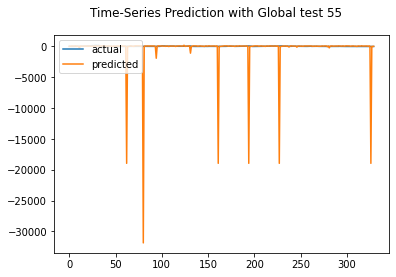

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 642.049
Test RMSE: 722.422
Test sMAPE: 197.777
Test R Squared: -539.038
{'mae': 642.0485753492876, 'rmse': 722.4224158107558, 'smape': 197.7770981594991, 'r2': -539.0381338571783}


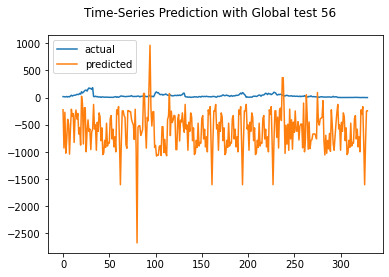

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 167.331
Test RMSE: 405.322
Test sMAPE: 158.560
Test R Squared: -168.998
{'mae': 167.33092085701045, 'rmse': 405.3221416446165, 'smape': 158.56010632474798, 'r2': -168.99754871195879}


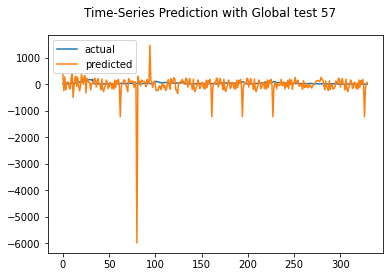

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 254.348
Test RMSE: 1033.341
Test sMAPE: 170.888
Test R Squared: -1103.915
{'mae': 254.34841775993507, 'rmse': 1033.3406781902786, 'smape': 170.8879489465949, 'r2': -1103.9154688102572}


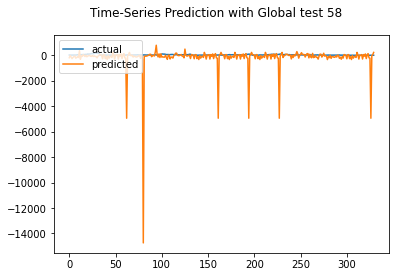

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 719.243
Test RMSE: 768.792
Test sMAPE: 183.029
Test R Squared: -610.589
{'mae': 719.2427757147586, 'rmse': 768.7921647662959, 'smape': 183.028919648399, 'r2': -610.5893282423865}


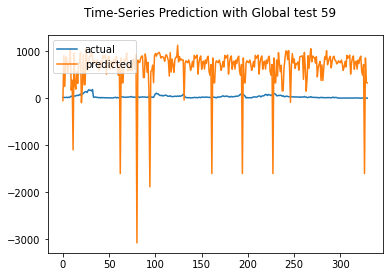

Test MAE: 270.097
Test RMSE: 1435.295
Test sMAPE: 126.567
Test R Squared: -2130.692
{'mae': 270.09665736248996, 'rmse': 1435.2950132419633, 'smape': 126.5674580862904, 'r2': -2130.691500439321}


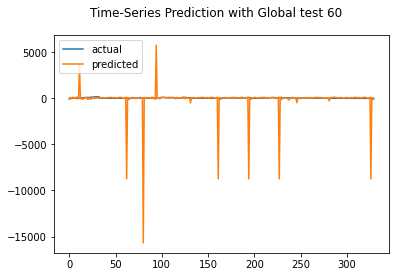

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAE: 105.299
Test RMSE: 294.312
Test sMAPE: 144.218
Test R Squared: -88.631
{'mae': 105.29909940343914, 'rmse': 294.3124133280131, 'smape': 144.21824301955903, 'r2': -88.63118979760468}


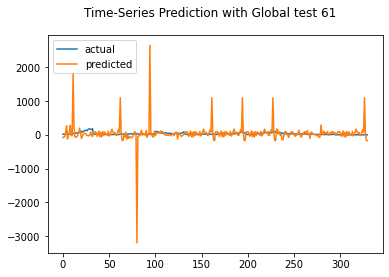

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 120.641
Test RMSE: 225.777
Test sMAPE: 151.354
Test R Squared: -51.747
{'mae': 120.64126078116172, 'rmse': 225.77656041379586, 'smape': 151.35390486130078, 'r2': -51.74723594090352}


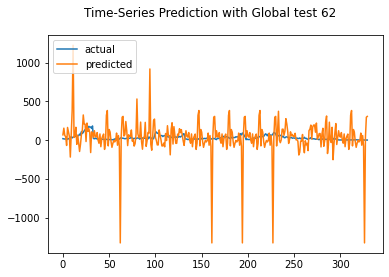

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 157.172
Test RMSE: 445.391
Test sMAPE: 152.994
Test R Squared: -204.269
{'mae': 157.17225566867626, 'rmse': 445.3905618708873, 'smape': 152.99440567190896, 'r2': -204.2693094328417}


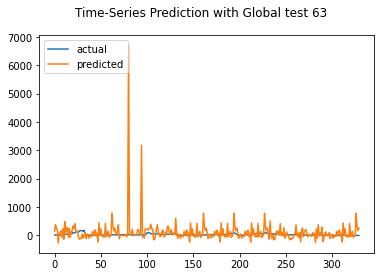

Test MAE: 90.672
Test RMSE: 310.619
Test sMAPE: 139.807
Test R Squared: -98.839
{'mae': 90.6720900925723, 'rmse': 310.61928197206487, 'smape': 139.80666101112385, 'r2': -98.83867865279136}


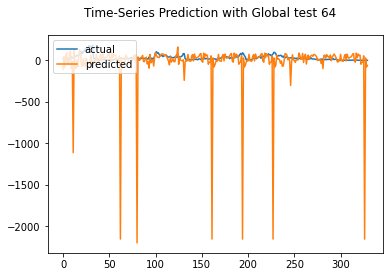

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 52.983
Test RMSE: 84.270
Test sMAPE: 116.473
Test R Squared: -6.348
{'mae': 52.98290807803472, 'rmse': 84.27015701890704, 'smape': 116.47290499486873, 'r2': -6.348346184036069}


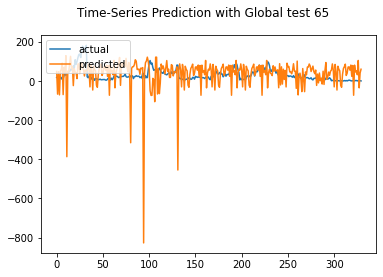

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 614.119
Test RMSE: 732.879
Test sMAPE: 178.882
Test R Squared: -554.784
{'mae': 614.1194836240826, 'rmse': 732.8785953215827, 'smape': 178.8818060684438, 'r2': -554.7840474297649}


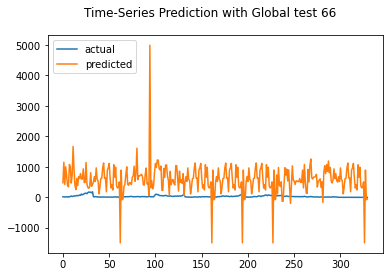

Test MAE: 152.975
Test RMSE: 874.834
Test sMAPE: 122.526
Test R Squared: -790.943
{'mae': 152.97500976829818, 'rmse': 874.83434979239, 'smape': 122.52643290364134, 'r2': -790.9425098640745}


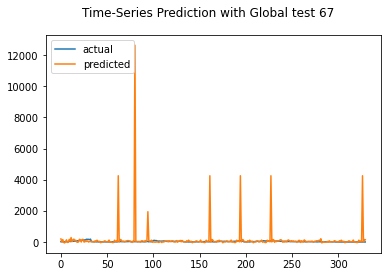

Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Test MAE: 113.129
Test RMSE: 222.529
Test sMAPE: 134.217
Test R Squared: -50.241
{'mae': 113.12901286211881, 'rmse': 222.52907627398534, 'smape': 134.2173613108533, 'r2': -50.24075639375906}


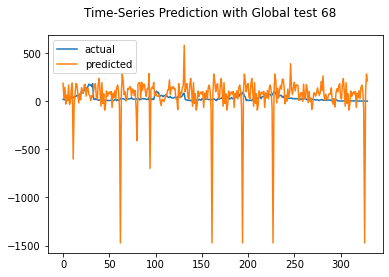

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 152.972
Test RMSE: 229.523
Test sMAPE: 155.287
Test R Squared: -53.512
{'mae': 152.97188314380068, 'rmse': 229.52311921334012, 'smape': 155.287257078585, 'r2': -53.512346444532035}


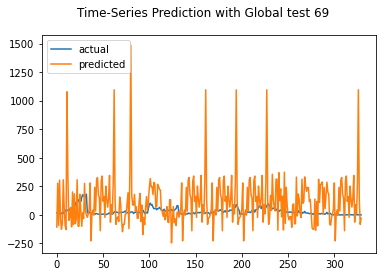

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 744.868
Test RMSE: 917.016
Test sMAPE: 183.395
Test R Squared: -869.153
{'mae': 744.8682755441376, 'rmse': 917.0159159973724, 'smape': 183.39484920564868, 'r2': -869.1532540368686}


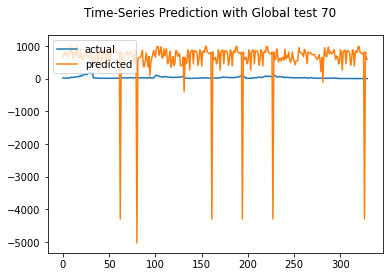

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 294.024
Test RMSE: 1196.362
Test sMAPE: 165.890
Test R Squared: -1480.042
{'mae': 294.0237066442316, 'rmse': 1196.362053141786, 'smape': 165.88961876096488, 'r2': -1480.0416107137507}


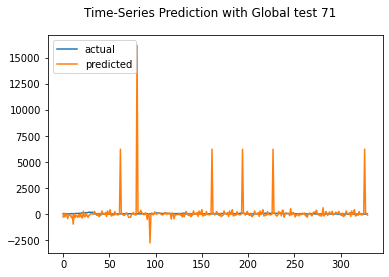

Test MAE: 378.618
Test RMSE: 2448.985
Test sMAPE: 94.872
Test R Squared: -6205.035
{'mae': 378.61794758998985, 'rmse': 2448.984882400854, 'smape': 94.8722881567274, 'r2': -6205.034851262518}


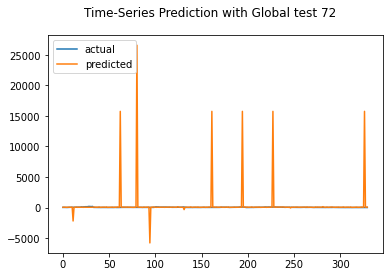

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 405.169
Test RMSE: 712.363
Test sMAPE: 190.875
Test R Squared: -524.104
{'mae': 405.1691264058604, 'rmse': 712.3634365167644, 'smape': 190.87452733987462, 'r2': -524.1038981503509}


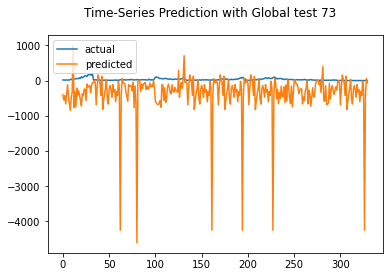

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 356.582
Test RMSE: 421.037
Test sMAPE: 168.772
Test R Squared: -182.435
{'mae': 356.5821192378348, 'rmse': 421.0372148094832, 'smape': 168.7724092470112, 'r2': -182.43532348525272}


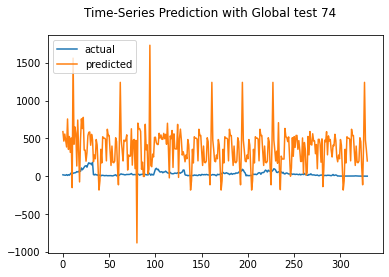

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 148.473
Test RMSE: 247.117
Test sMAPE: 140.315
Test R Squared: -62.190
{'mae': 148.47325851826957, 'rmse': 247.1165669405637, 'smape': 140.31457750182992, 'r2': -62.189617353373066}


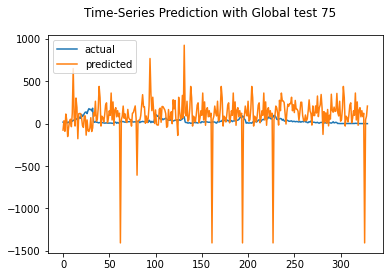

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 1660.187
Test RMSE: 3320.302
Test sMAPE: 199.756
Test R Squared: -11406.673
{'mae': 1660.1872683900776, 'rmse': 3320.3016392076684, 'smape': 199.75605327111657, 'r2': -11406.67346297613}


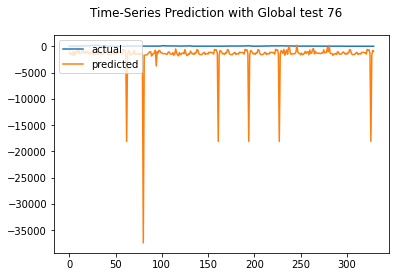

Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Test MAE: 103.442
Test RMSE: 417.031
Test sMAPE: 117.320
Test R Squared: -178.961
{'mae': 103.44201517394094, 'rmse': 417.03122555882754, 'smape': 117.3199539785724, 'r2': -178.96131185726676}


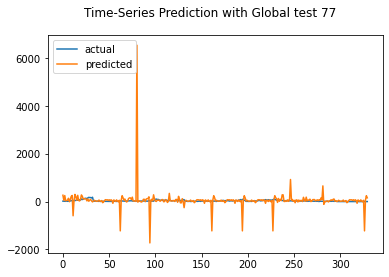

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 1081.460
Test RMSE: 1344.281
Test sMAPE: 188.464
Test R Squared: -1868.917
{'mae': 1081.4602696274267, 'rmse': 1344.2813544697929, 'smape': 188.46430020261573, 'r2': -1868.917092669352}


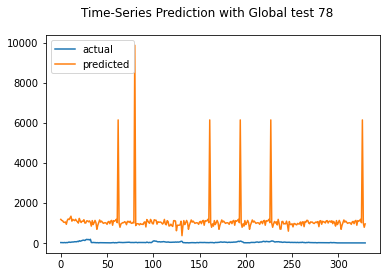

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Test MAE: 92.886
Test RMSE: 204.154
Test sMAPE: 125.631
Test R Squared: -42.128
{'mae': 92.88594975814675, 'rmse': 204.15411124115613, 'smape': 125.6308979679923, 'r2': -42.12789504582965}


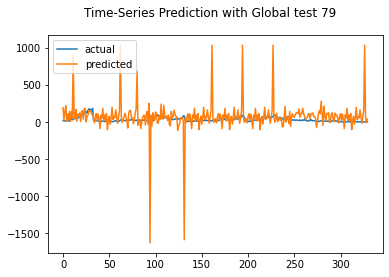

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 90.885
Test RMSE: 277.185
Test sMAPE: 114.147
Test R Squared: -78.502
{'mae': 90.88519613182906, 'rmse': 277.1847398831696, 'smape': 114.1471326149704, 'r2': -78.50247255896555}


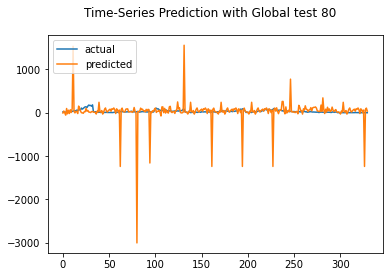

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 89.533
Test RMSE: 156.979
Test sMAPE: 142.078
Test R Squared: -24.499
{'mae': 89.53299732858484, 'rmse': 156.9790195901641, 'smape': 142.07761218397874, 'r2': -24.49912197629449}


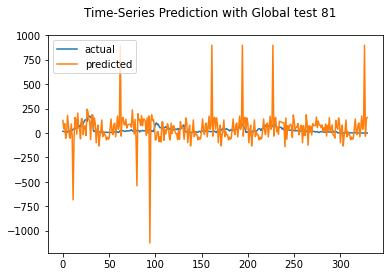

Test MAE: 142.538
Test RMSE: 563.691
Test sMAPE: 131.294
Test R Squared: -327.794
{'mae': 142.53786544709496, 'rmse': 563.6911772357555, 'smape': 131.29430655938637, 'r2': -327.794448751737}


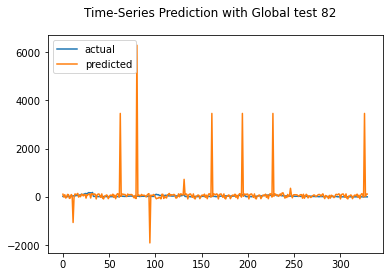

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 588.025
Test RMSE: 3836.840
Test sMAPE: 142.517
Test R Squared: -15232.139
{'mae': 588.0247201886141, 'rmse': 3836.840107815059, 'smape': 142.51737241234702, 'r2': -15232.138973263884}


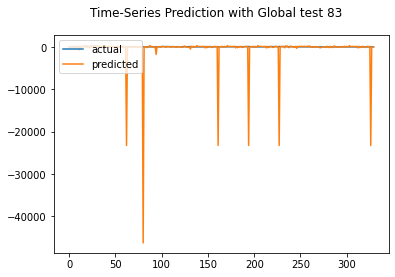

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 270.428
Test RMSE: 1041.609
Test sMAPE: 145.727
Test R Squared: -1121.668
{'mae': 270.42785908670135, 'rmse': 1041.6089791992392, 'smape': 145.72728211400656, 'r2': -1121.668227293083}


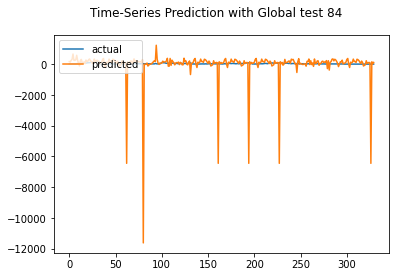

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 170.142
Test RMSE: 244.691
Test sMAPE: 166.978
Test R Squared: -60.955
{'mae': 170.1424571167339, 'rmse': 244.69111706666752, 'smape': 166.978192551241, 'r2': -60.955292097934006}


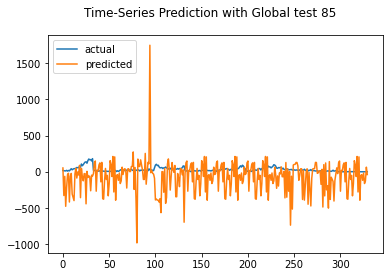

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAE: 173.180
Test RMSE: 505.569
Test sMAPE: 148.469
Test R Squared: -263.486
{'mae': 173.18046700412577, 'rmse': 505.56850638934066, 'smape': 148.46874475061173, 'r2': -263.4855968146201}


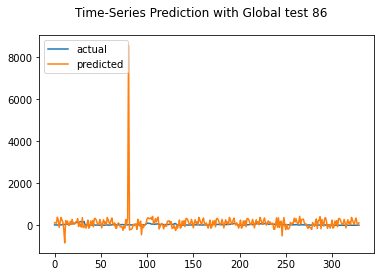

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 1292.501
Test RMSE: 1730.149
Test sMAPE: 190.111
Test R Squared: -3096.485
{'mae': 1292.500650729555, 'rmse': 1730.1493831209318, 'smape': 190.11067494900027, 'r2': -3096.484958805317}


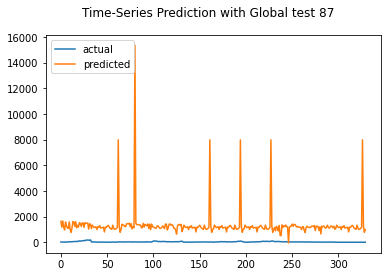

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 215.289
Test RMSE: 531.147
Test sMAPE: 170.572
Test R Squared: -290.925
{'mae': 215.28881707913948, 'rmse': 531.1465129390762, 'smape': 170.57175721655867, 'r2': -290.92458459579575}


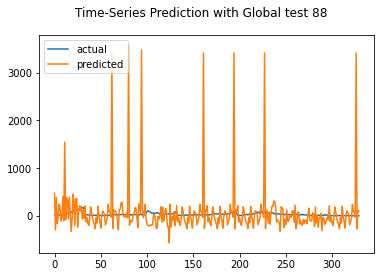

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 804.332
Test RMSE: 1442.431
Test sMAPE: 199.068
Test R Squared: -2151.942
{'mae': 804.3319411696809, 'rmse': 1442.4312317925426, 'smape': 199.06814140644363, 'r2': -2151.9415340521846}


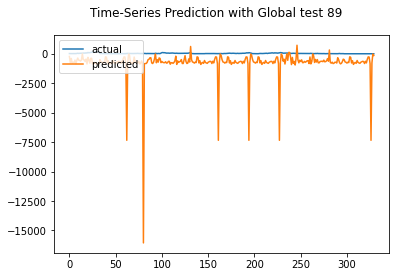

Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Test MAE: 107.761
Test RMSE: 461.380
Test sMAPE: 119.438
Test R Squared: -219.272
{'mae': 107.76061466209816, 'rmse': 461.38026497643716, 'smape': 119.43804461345258, 'r2': -219.27237270716674}


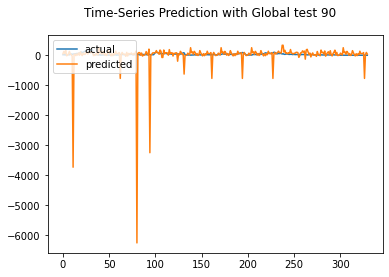

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 972.702
Test RMSE: 2554.356
Test sMAPE: 181.580
Test R Squared: -6750.573
{'mae': 972.702186237682, 'rmse': 2554.3563215135155, 'smape': 181.57953450079862, 'r2': -6750.572884727216}


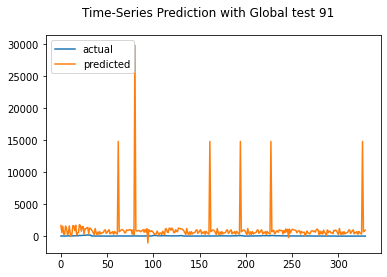

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 190.119
Test RMSE: 462.204
Test sMAPE: 157.549
Test R Squared: -220.060
{'mae': 190.11895513290708, 'rmse': 462.20428218440765, 'smape': 157.54901074874005, 'r2': -220.0598806463849}


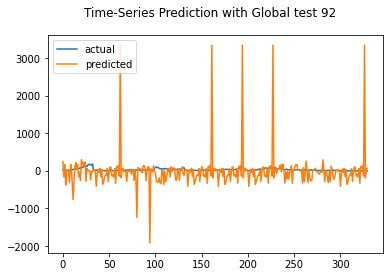

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 316.409
Test RMSE: 466.462
Test sMAPE: 162.487
Test R Squared: -224.151
{'mae': 316.40945375037916, 'rmse': 466.46163529235764, 'smape': 162.4873393155983, 'r2': -224.15099087494113}


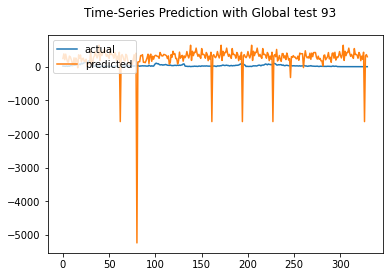

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Test MAE: 104.331
Test RMSE: 354.614
Test sMAPE: 116.261
Test R Squared: -129.123
{'mae': 104.33074822317471, 'rmse': 354.61378363689, 'smape': 116.26075490547498, 'r2': -129.12274801410763}


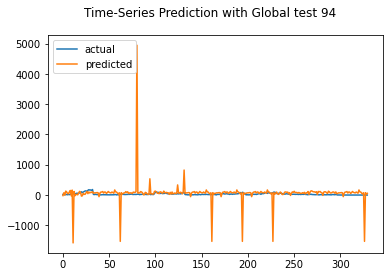

Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
Test MAE: 74.101
Test RMSE: 114.298
Test sMAPE: 129.583
Test R Squared: -12.518
{'mae': 74.10115878654248, 'rmse': 114.29795564141897, 'smape': 129.58300421804748, 'r2': -12.518201846866319}


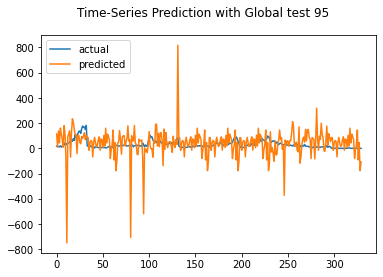

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 888.130
Test RMSE: 992.671
Test sMAPE: 194.723
Test R Squared: -1018.653
{'mae': 888.1297663081776, 'rmse': 992.6705233143974, 'smape': 194.72302251177734, 'r2': -1018.6526532095036}


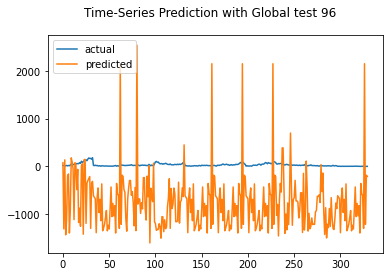

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 173.589
Test RMSE: 265.650
Test sMAPE: 157.035
Test R Squared: -72.023
{'mae': 173.5891974936832, 'rmse': 265.6501698220178, 'smape': 157.03500489061554, 'r2': -72.02342478440308}


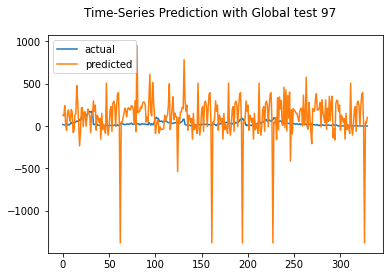

Test MAE: 244.692
Test RMSE: 1443.428
Test sMAPE: 113.932
Test R Squared: -2154.917
{'mae': 244.69239440686775, 'rmse': 1443.4275208247595, 'smape': 113.93210665520795, 'r2': -2154.9166399020824}


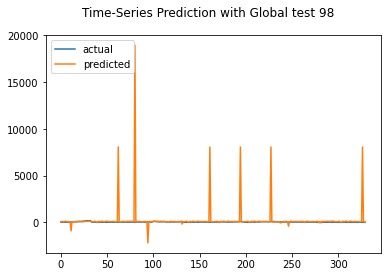

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 768.663
Test RMSE: 1274.072
Test sMAPE: 199.638
Test R Squared: -1678.692
{'mae': 768.6629725225044, 'rmse': 1274.0715683336928, 'smape': 199.63780913799343, 'r2': -1678.6919862667721}


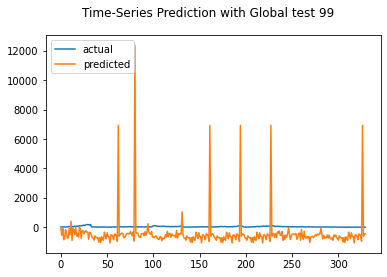

rmse : average=867.788, std=808.162
mae : average=401.659, std=434.237
smape : average=157.027, std=25.737
r2 : average=-1454.069, std=2638.190


([867.7878152186481, 808.1624018660106],
 [401.659343156019, 434.23715899552604],
 [157.0265918588685, 25.736799640037866],
 [-1454.0689907661022, 2638.1898194391647])

In [14]:
# Use the Function:
if T != 0: 
    sequence=train_X.shape[1]
    features=train_X.shape[2]
else:
    sequence=T
    features=train_X.shape[1]

calculate_mean_std(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scalers['scaler_Labels'], monitor=True, plot=None, epochs=50, batch_size=16, n_tests=100, plot_samples=True, Municipality='Global')